In [1]:
%load_ext autoreload
%autoreload 2

import os
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import sys
#show the pass to chocolat module
sys.path.append('../')
plt.rcParams['pdf.fonttype'] = 42

In [2]:
# Load experiment anndata objects

andata_folder = '../data/composed_anndata_objects_2024_01_30'

# List all files in the 'tidy' folder
file_list = os.listdir(andata_folder)

adata_dict = {}
for file in file_list:
    if file.endswith('.h5ad'):
        ref_code = file[:-5]  # Remove the '.h5ad' extension
        
        filepath = os.path.join(andata_folder, file)
        adata = sc.read_h5ad(filepath)
        adata.obsm['spatial'] = adata.obsm['spatial'].astype(int) # To ensure spatial coordinates are numerical
        adata.obs['histo_annotation_num'][[str(x).startswith("Normal") for x in adata.obs['histo_annotation_num']]] = 'NaN' # Remove normal annotation from numberical ids
        adata_dict[ref_code] = adata

In [3]:
# Load filtere anndata objects

filtered_anndata_folder = '../data/filtered-anndata'
file_list = os.listdir(filtered_anndata_folder)

adata_dict_filtered = {}
for file in file_list:
    if file.endswith('.h5ad'):
        ref_code = file[:-5]  # Remove the '.h5ad' extension
        
        filepath = os.path.join(filtered_anndata_folder, file)
        adata = sc.read_h5ad(filepath)
        adata.obsm['spatial'] = adata.obsm['spatial'].astype(int) # To ensure spatial coordinates are numerical
        adata_dict_filtered[ref_code] = adata

In [4]:
# Load inferred perturbations probability posteriors

# Load saved model samples
with open('../data/model_outputs/samples_genotyping_model.npy', 'rb') as file:
    samples_dict = np.load(file, allow_pickle=True).item()

In [5]:
# Load plasmid encoding table

plasmids_df = pd.read_csv('../data/plasmid_code.csv')
plasmids_matrix = pd.pivot_table(plasmids_df, index='List', columns='Name', values='FeatureType',
                                 aggfunc=lambda x: 1, fill_value=0)
reporters = list(plasmids_matrix.columns)

plasmids_ordered_list = ['MYC-plasmid', 'mtCtnnb1', 'coVEGFA-plasmid',
                         'shMLL3-plasmid', 'NICD-plasmid', 'shRen-plasmid', 'shtrp53-plasmid', 'shPTEN-plasmid']

colours = {
    "MYC-plasmid": "#56b4e9",  # Blue
    "coVEGFA-plasmid": "#cc79a7",  # Orange
    "NICD-plasmid": "#e69f00",  # Green
    "shRen-plasmid": "#f0e442",  # Red
    "shtrp53-plasmid": "#d55e00",  # Purple
    "shPTEN-plasmid" : "#009e73",  # Brown
    "shMLL3-plasmid": "#0072b2",  # Pink
    "mtCtnnb1": "#000000",  # Grey
}

## CHOCOLAT-G2P Barcode properties

In [6]:
from chocolat.preprocessing import compute_quantiles, annotate_normal_cancer
from chocolat.models import prepare_data4genotype_models
from chocolat.plt import plot_spatial_barcodes_average, plot_spatial_pertrubation_probabilities
from chocolat.plt import plot_average_barcode_expression

/lustre/scratch127/casm/team299ly/al15/miniconda3/envs/chocolat-g2p/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


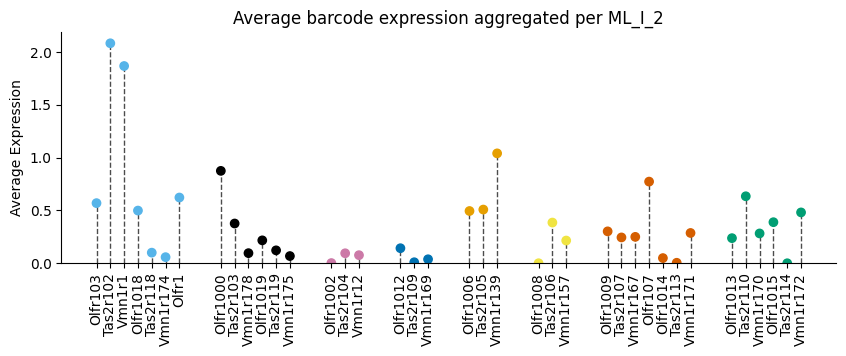

In [7]:
plot_average_barcode_expression(adata_dict, plasmids_df,
                                plasmids_ordered_list,
                                ['ML_I_2'])

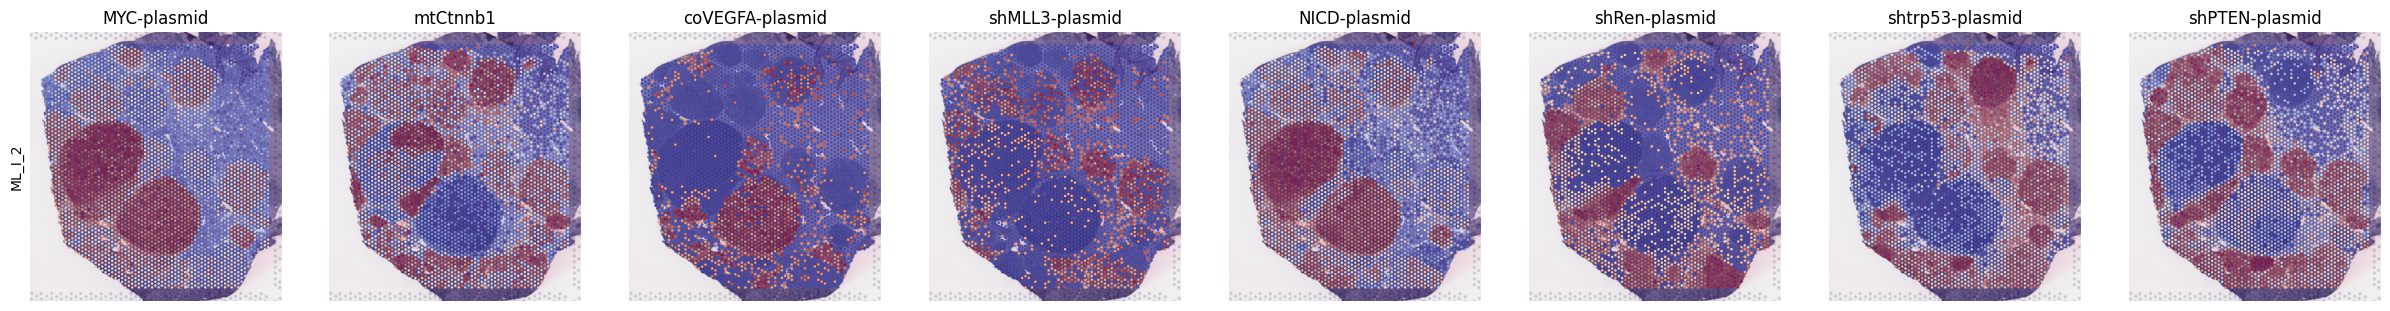

In [8]:
plot_spatial_barcodes_average(adata_dict, plasmids_df, plasmids_ordered_list, ['ML_I_2'])

Prepared data for the following samples: 
ML_I_2


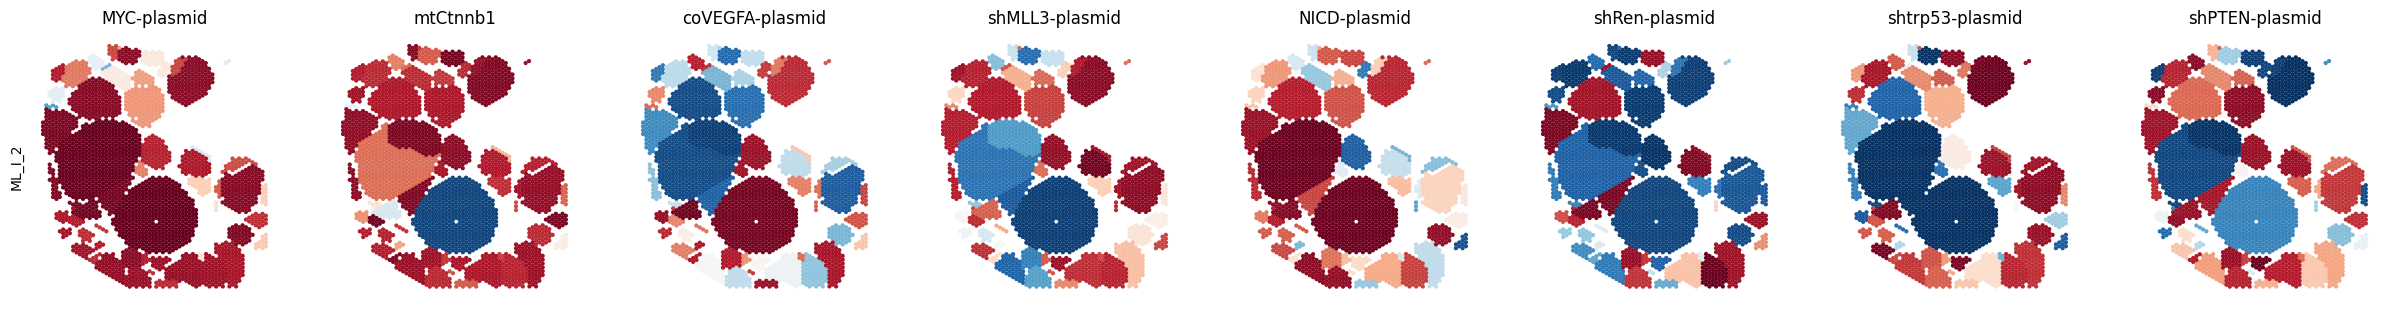

In [9]:
_, _, region_ids_tensor, plasmid_matrix_tensor = prepare_data4genotype_models(adata_dict_filtered, reporters, plasmids_matrix.values,
                                                                                  region_id_column='histo_annotation_num',
                                                                                  keys=['ML_I_2'],
                                                                                  device='cpu')

plot_spatial_pertrubation_probabilities(adata_dict_filtered,
                                        samples_dict,
                                        region_ids_tensor,
                                        plasmids=plasmids_ordered_list,
                                        keys=['ML_I_2'])

## Predicting IHC status based on inferred perturbation probabilties 

In [10]:
from chocolat.models import ModelGlmmBernoulli, GuideGlmmBernoulli, prepare_data4glmm, load_ihc_annotation, train_glm_models
from chocolat.plt import plot_glmm_weights

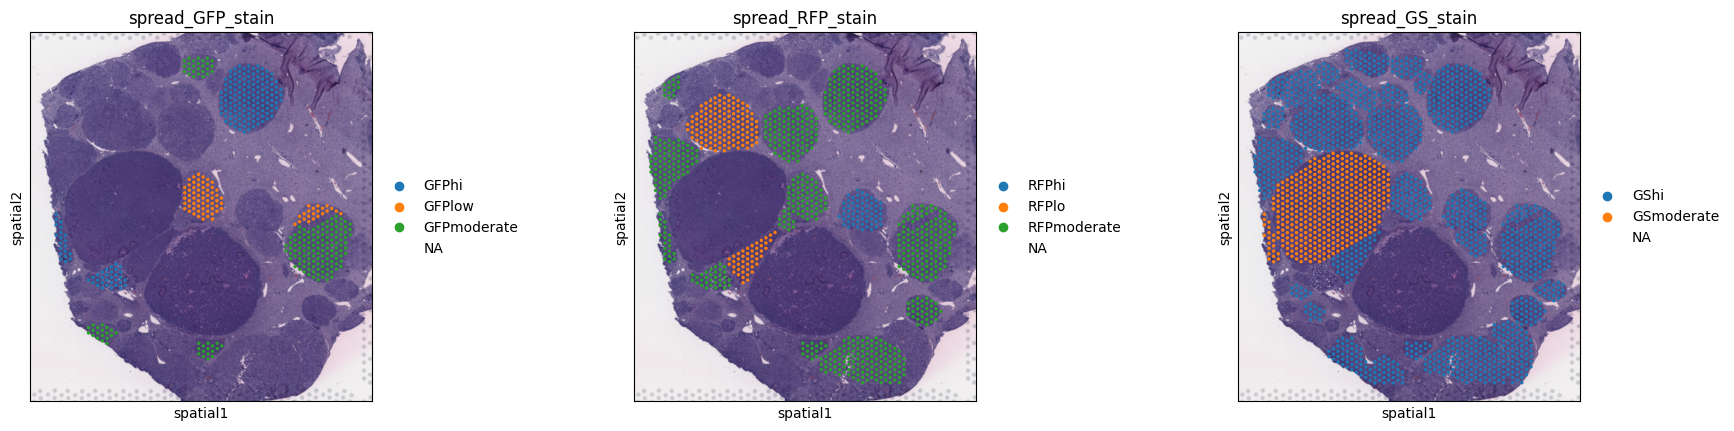

In [11]:
binary_feature_list = ['GFP', 'RFP', 'GS']
keys_6ROI = ['ML_III_A', 'ML_III_B', 'ML_II_A_1',
           'ML_II_B',
           'ML_II_C', 'ML_I_2']

observations_dict = load_ihc_annotation(adata_dict_filtered, binary_feature_list, keys=keys_6ROI, folder='../data/IHCs_12ROIs/')

sc.pl.spatial(adata_dict_filtered['ML_I_2'], img_key="lowres",
              color=['spread_GFP_stain', 'spread_RFP_stain', 'spread_GS_stain'])

In [12]:
(prior_parametrisation_tensor_dict, region_indices_stacked,
 sample_indices_by_region, sample_indices_stacked, 
 observations_tensor, observations_by_region) = prepare_data4glmm(adata_dict_filtered, samples_dict, observations_dict, keys=keys_6ROI)

mean_marginal, variance_marginal, loss_list = train_glm_models(prior_parametrisation_tensor_dict,
                                                               region_indices=region_indices_stacked,
                                                               sample_indices=sample_indices_by_region,
                                                               observations_tensor=observations_tensor,
                                                               obs=observations_by_region,
                                                               model=ModelGlmmBernoulli,
                                                               guide=GuideGlmmBernoulli)

/lustre/scratch127/casm/team299ly/al15/projects/CHOCOLAT-G2P/notebooks/../chocolat/models/_glm_model.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.inferred_spot_sensitivity = torch.tensor(inferred_spot_sensitivity, device=device)
/lustre/scratch127/casm/team299ly/al15/projects/CHOCOLAT-G2P/notebooks/../chocolat/models/_glm_model.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.inferred_region_params = torch.tensor(inferred_region_params, device=device)
/lustre/scratch127/casm/team299ly/al15/projects/CHOCOLAT-G2P/notebooks/../chocolat/models/_glm_model.py:157: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourc

using cpu


Processing:   0%|                                                                 | 0/1000 [00:00<?, ?it/s]/lustre/scratch127/casm/team299ly/al15/miniconda3/envs/chocolat-g2p/lib/python3.11/site-packages/pyro/util.py:303: UserWarning: Found vars in model but not guide: {'region_params'}
  warnings.warn(f"Found vars in model but not guide: {bad_sites}")
/lustre/scratch127/casm/team299ly/al15/miniconda3/envs/chocolat-g2p/lib/python3.11/site-packages/pyro/util.py:303: UserWarning: Found vars in model but not guide: {'region_params'}
  warnings.warn(f"Found vars in model but not guide: {bad_sites}")
Processing: 100%|███████████████████████████████████████| 1000/1000 [01:08<00:00, 14.66it/s, loss=-3.73e+3]


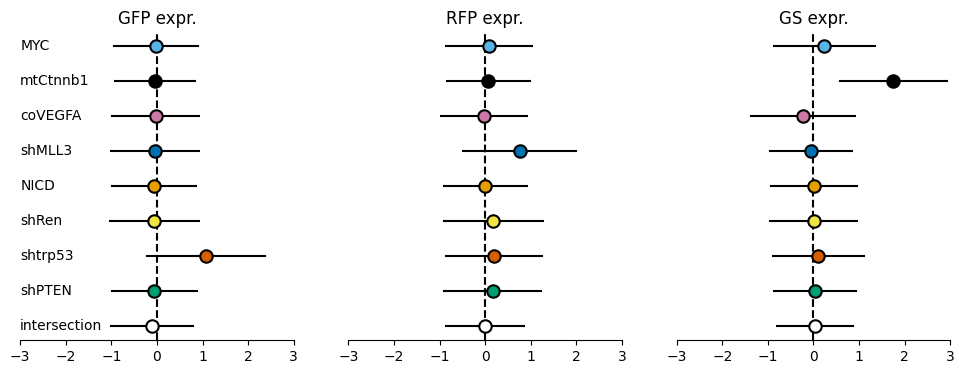

In [13]:
plot_glmm_weights(mean_marginal,
                  variance_marginal,
                  plasmids_ordered_list,
                  binary_feature_list,
                  dim=(1,3))

## Predicting target expression based on inferred perturbation probabilties

In [14]:
from chocolat.models import ModelGlmmPoisson, GuideGlmmPoisson

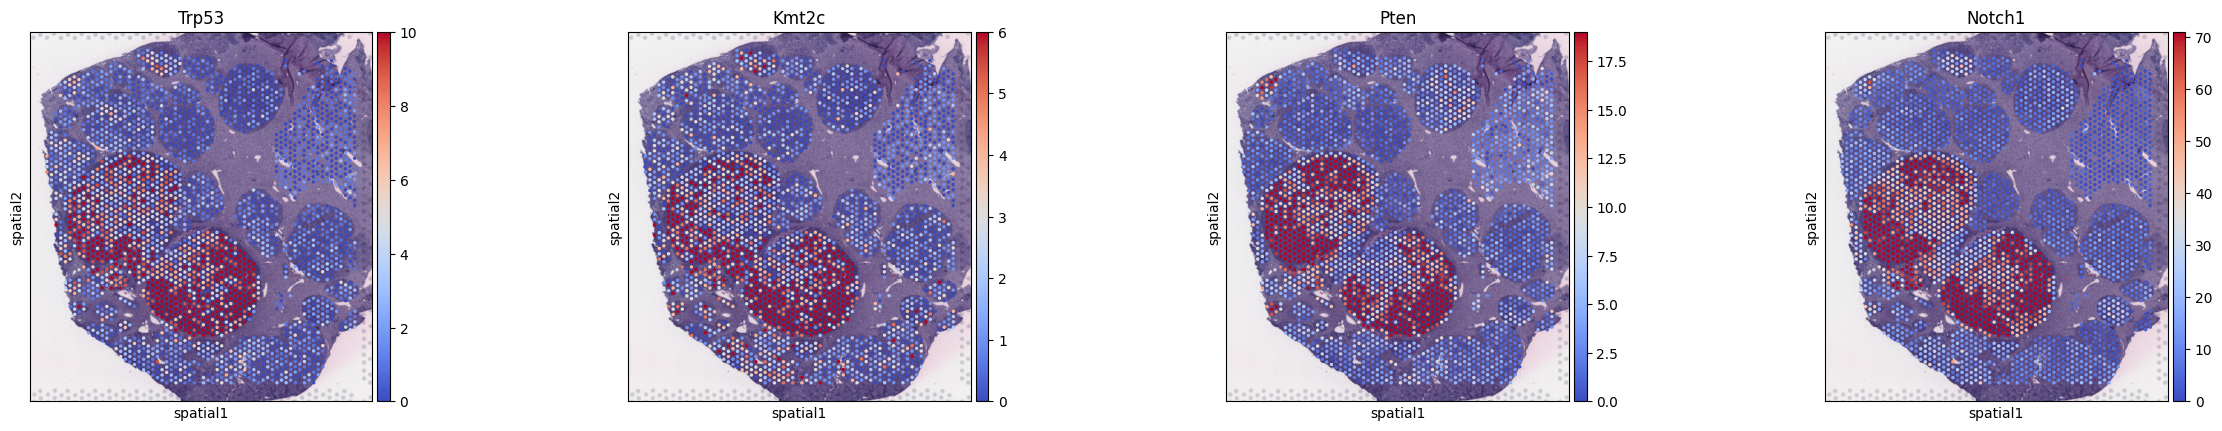

In [15]:
gene_list = ['Trp53', 'Kmt2c', 'Pten', 'Notch1']
keys_6ROI = ['ML_III_A', 'ML_III_B', 'ML_II_A_1',
           'ML_II_B',
           'ML_II_C', 'ML_I_2']

observations_dict = {}
for key in keys_6ROI:
    observations_dict[key] = np.array(adata_dict_filtered[key][:,gene_list].X.todense())
    
sc.pl.spatial(adata_dict_filtered['ML_I_2'], img_key="lowres",
              color=gene_list, cmap='coolwarm', vmax='p90')

In [16]:
(prior_parametrisation_tensor_dict, region_indices_stacked,
 sample_indices_by_region, sample_indices_stacked, 
 observations_tensor, observations_by_region) = prepare_data4glmm(adata_dict_filtered, samples_dict, observations_dict, keys=keys_6ROI)

mean_marginal, variance_marginal, loss_list = train_glm_models(prior_parametrisation_tensor_dict,
                                                               region_indices=region_indices_stacked,
                                                               sample_indices=sample_indices_stacked,
                                                               observations_tensor=observations_tensor,
                                                               obs=observations_tensor,
                                                               model=ModelGlmmPoisson,
                                                               guide=GuideGlmmPoisson)

using cuda


/lustre/scratch127/casm/team299ly/al15/projects/CHOCOLAT-G2P/notebooks/../chocolat/models/_glm_model.py:232: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.inferred_spot_sensitivity = torch.tensor(inferred_spot_sensitivity, device=device)
/lustre/scratch127/casm/team299ly/al15/projects/CHOCOLAT-G2P/notebooks/../chocolat/models/_glm_model.py:233: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.inferred_region_params = torch.tensor(inferred_region_params, device=device)
/lustre/scratch127/casm/team299ly/al15/projects/CHOCOLAT-G2P/notebooks/../chocolat/models/_glm_model.py:306: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sou

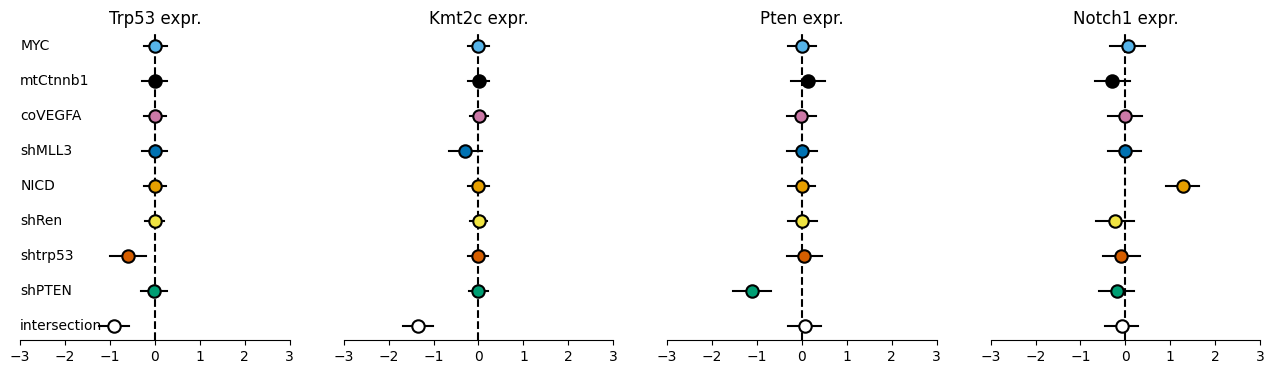

In [17]:
plot_glmm_weights(mean_marginal,
                  variance_marginal,
                  plasmids_ordered_list,
                  gene_list,
                  dim=(1,4))

## Seqential data consistency

In [18]:
import pickle as pkl
from chocolat.plt import plot_seqential_pred_correlations

In [19]:
correspondent_annotations = pd.read_csv('../data/nodule_cross_annotation.csv', sep=';')

with open('../data/model_outputs/plasmid_probs-all-samples-final.pkl', 'rb') as file:
    aggregated_results_dict = pkl.load(file)
    
predicted_composition_df = pd.DataFrame(data = aggregated_results_dict['probs'],
             columns=aggregated_results_dict['plasmids'],
             index=[aggregated_results_dict['samples'], aggregated_results_dict['names']])

ML_I_2 ML_I 31
ML_III_A ML_III_A_2Cyt 43
ML_II_A_1 ML_II_A_2 36
ML_II_A_1 ML_II_A_3Cyt 11
ML_II_B ML_II_B_3Cyt 15


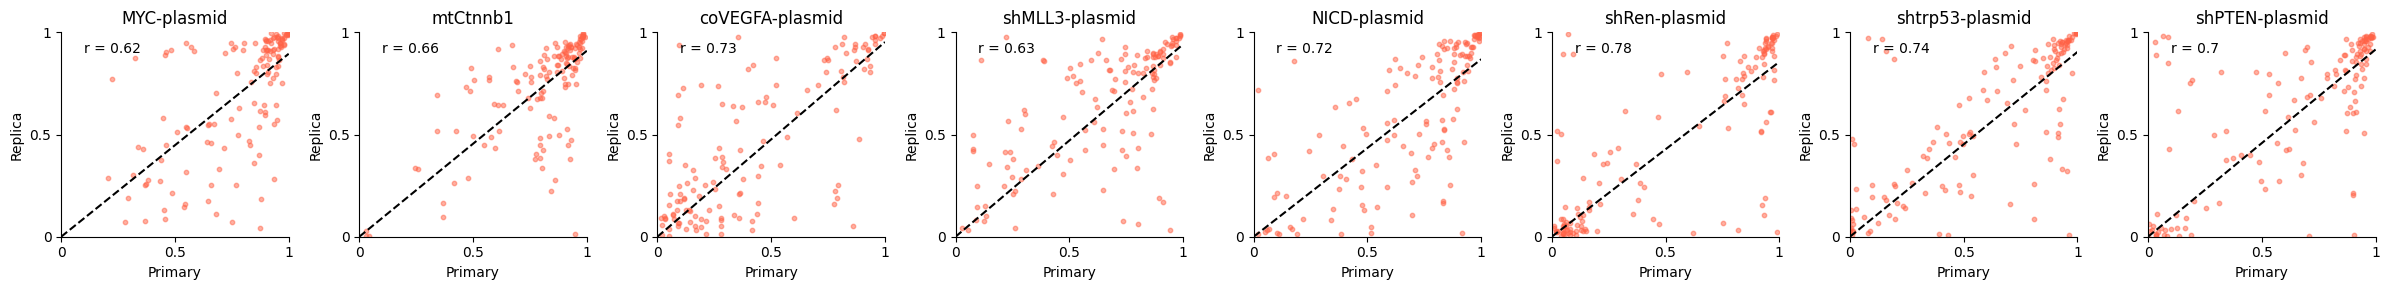

In [20]:
corresponding_samples = [['ML_I','ML_I_2'], ['ML_III_A','ML_III_A_2Cyt'],
                         ['ML_II_A_1', 'ML_II_A_2'], ['ML_II_A_1', 'ML_II_A_3Cyt'], ['ML_II_B', 'ML_II_B_3Cyt']]

corresponding_column = ['match_nodule_r2', 'match_nodule_r2', 'match_nodule_r2', 'match_nodule_r3', 'match_nodule_r3']

plot_seqential_pred_correlations(predicted_composition_df,
                                 correspondent_annotations,
                                 corresponding_samples,
                                 corresponding_column,
                                 plasmids_ordered_list)